In [64]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [65]:
class TensorNetwork:
    def __init__(self, graph, tensors):
        self.graph = graph
        self.tensors = tensors
        self.index_dims = {}
        self.index_to_tensors = {}

        for name, (tensor, indices) in tensors.items():
            for idx, dim in zip(indices, tensor.shape):
                if idx in self.index_dims:
                    assert self.index_dims[idx] == dim, f"Index {idx} has conflicting dimensions: {self.index_dims[idx]} and {dim}"
                else:
                    self.index_dims[idx] = dim
                self.index_to_tensors.setdefault(idx, []).append((name, tensor, indices))


In [66]:
def evaluate_config(network, config):
    result = 1.0
    for name, (tensor, inds) in network.tensors.items():
        key = tuple(config[idx] for idx in inds)
        result *= tensor[key]
    return result

def update_edge(network, config, idx):
    tensors = network.index_to_tensors[idx]
    dim = network.index_dims[idx]
    probs = np.ones(dim)
    for name, arr, inds in tensors:
        pos = inds.index(idx)
        slc = [config[i] if i != idx else slice(None) for i in inds]
        probs *= arr[tuple(slc)]
    if probs.sum() == 0:
        probs = np.ones(dim) / dim
    else:
        probs /= probs.sum()
    
    config[idx] = np.random.choice(dim, p=probs)

def estimate_contraction(network, betas, iters=10000, burns=1000, verbose=True, return_traj=False):
    config = {idx: np.random.randint(dim) for idx, dim in network.index_dims.items()}
    logZ = 0.0
    logZ_trajectory = [0.0]

    for i in range(1, len(betas)):
        beta_prev, beta_curr = betas[i - 1], betas[i]
        delta_beta = beta_curr - beta_prev
        weights = []

        for t in range(iters):
            idx = np.random.choice(list(network.index_dims.keys()))
            update_edge(network, config, idx)
            if t >= burns:
                w = evaluate_config(network, config)
                if w > 0:
                    weights.append(w ** (-delta_beta))

        weights = np.array(weights)
        if weights.size == 0 or np.mean(weights) == 0:
            if verbose:
                print(f"[β = {beta_curr:.2f}] Warning: All weights zero. Skipping this interval.")
            continue

        logZ += -np.log(np.mean(weights))
        logZ_trajectory.append(logZ)
        if verbose:
            print(f"[β = {beta_curr:.2f}] E[ψ^(-Δβ)] = {np.mean(weights):.6f} → partial logZ = {logZ:.6f}")

    # multiply by the number of total configurations (uniform base measure)
    total_configurations = np.prod([dim for dim in network.index_dims.values()])
    Z_estimate = np.exp(logZ) * total_configurations

    if return_traj:
        return Z_estimate, logZ_trajectory
    return Z_estimate

In [67]:
# testing networks
def generate_cycle_network(N=4, D=3):
    G = nx.cycle_graph(N)
    tensors = {}
    for i in G.nodes():
        neighbors = sorted(G.neighbors(i))
        idx_1, idx_2 = f'e{i}-{neighbors[0]}', f'e{i}-{neighbors[1]}'
        tensor = np.random.rand(D, D)
        tensors[i] = (tensor, [idx_1, idx_2])
    return TensorNetwork(G, tensors)

def generate_random_graph_tn(n=6, p=0.4, D=2):
    G = nx.erdos_renyi_graph(n, p)
    tensors = {}
    edge_map = {}
    for u, v in G.edges():
        idx = f'e{u}-{v}'
        edge_map[(u, v)] = idx
        edge_map[(v, u)] = idx
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        idxs = [edge_map[(node, nbr)] for nbr in neighbors]
        shape = [D] * len(idxs)
        tensor = np.random.rand(*shape)
        tensors[node] = (tensor, idxs)
    
    return TensorNetwork(G, tensors)

def run_multiple_chains(network, betas, n_chains=5, iters=20000, burns=1000):
    estimates = []
    trajectories = []

    for seed in range(n_chains):
        np.random.seed(seed)
        Z_est, traj = estimate_contraction(
            network, betas, iters=iters, burns=burns, verbose=False, return_traj=True
        )
        estimates.append(Z_est)
        trajectories.append(traj)
    
    # plotting trajectories of log Z per beta to check smoothness
    for i, traj in enumerate(trajectories):
        plt.plot(betas, traj, label=f'Chain {i+1}')
    plt.xlabel('Beta')
    plt.ylabel('Accumulated Log Z')
    plt.title('Log Z Trajectories on Multiple Chains')
    plt.legend()
    plt.grid(True)
    plt.show()

    return np.mean(estimates), np.std(estimates)


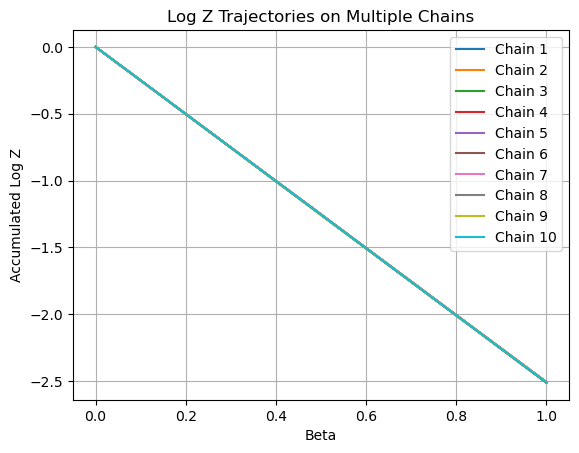

Estimated Z: 6.5765 ± 0.0137
True trace: 4.0617


In [70]:
# test on Tr(ABCD)

G = nx.Graph()
G.add_edges_from([
    ('A', 'B'),
    ('B', 'C'),
    ('C', 'D'),
    ('D', 'A'),
])

edge_labels = {
    ('A', 'B'): 'j',
    ('B', 'C'): 'k',
    ('C', 'D'): 'l',
    ('D', 'A'): 'i',
}

#define tensors with matching shared indices
dim = 3
A = np.random.rand(dim, dim)
B = np.random.rand(dim, dim)
C = np.random.rand(dim, dim)
D = np.random.rand(dim, dim)

tensors = {
    'A': (A, ['i', 'j']),
    'B': (B, ['j', 'k']),
    'C': (C, ['k', 'l']),
    'D': (D, ['l', 'i'])
}

tn = TensorNetwork(G, tensors)
betas = np.linspace(0, 1, 50)
n_chains = 10
iters = 20000
burns = 1000

mean_Z, std_Z = run_multiple_chains(tn, betas, n_chains=n_chains, iters=iters, burns=burns)
tensors = tn.tensors

A, B, C, D = [tensors[i][0] for i in sorted(tensors)]
true_trace = np.trace(A @ B @ C @ D)

print(f"Estimated Z: {mean_Z:.4f} ± {std_Z:.4f}")
print(f"True trace: {true_trace:.4f}")